In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import commons
import textwrap
import math

In [2]:
# load data and ratings about open-source projects

features = set()
scores = set()
data = []
score_weights = {}

def process_used_score_value(used_value, row, score_weights):
    score_type = used_value['score']['type']
    if used_value['isNotApplicable']:
        row[score_type] = 'N/A'
    else:
        row[score_type] = used_value['value']
    if score_type not in score_weights:
        score_weights[score_type] = used_value['weight']
    elif score_weights[score_type] != used_value['weight']:
        raise Exception('Oops! Weights do not match!')

def process_vulnerability_value(used_value, row):
    row['# of vulnerabilities'] = len(used_value['vulnerabilities']['entries'])
    row['# of unpatched vulnerabilities'] = 0
    row['# of patched vulnerabilities'] = 0
    row['# of vulnerabilities without introduced date'] = 0
    row['# of vulnerabilities without fixed date'] = 0
    for entry in used_value['vulnerabilities']['entries']:
        if entry['resolution'] == 'UNPATCHED':
            row['# of unpatched vulnerabilities'] = row['# of unpatched vulnerabilities'] + 1
        elif entry['resolution'] == 'PATCHED':
            row['# of patched vulnerabilities'] = row['# of patched vulnerabilities'] + 1
        if entry['introduced'] is None:
            row['# of vulnerabilities without introduced date'] = row['# of vulnerabilities without introduced date'] + 1
        if entry['fixed'] is None:
            row['# of vulnerabilities without fixed date'] = row['# of vulnerabilities without fixed date'] + 1
        
def process_sub_scores(score_value, row, score_weights):
    for used_value in score_value['usedValues']:
        if used_value['type'] == 'ScoreValue':
            scores.add(used_value['score']['type'])
            process_used_score_value(used_value, row, score_weights)
            process_sub_scores(used_value, row, score_weights)
            continue
        
        feature = used_value['feature']['name']
        features.add(feature)
          
        if used_value['type'] == 'UnknownValue':
            row[feature] = 'unknown'
        elif used_value['type'] == 'VulnerabilitiesValue':
            process_vulnerability_value(used_value, row)
                
        elif used_value['type'] == 'IntegerValue':
            row[feature] = used_value['number']
        elif used_value['type'] == 'BooleanValue':
            row[feature] = used_value['flag']
        elif used_value['type'] == 'DateValue':
            row[feature] = used_value['date']
        elif used_value['type'] == 'LanguagesValue':
            row[feature] = used_value['languages']['elements']
        elif used_value['type'] == 'PackageManagersValue':
            row[feature] = used_value['packageManagers']['packageManagers']
        elif used_value['type'] == 'LgtmGradeValue':
            row[feature] = used_value['value']
        else:
            raise Exception('Unknown value type: ' + used_value['type'])

with open('../../../../../docs/oss/security/github_projects.json') as json_file:
    json_data = json.load(json_file)
    for json_project_data in json_data:
        row = {}
        row['URL'] = json_project_data['url']
        rating_value = json_project_data['ratingValue']
        if rating_value is None:
            continue
            
        row['Label'] = rating_value['label'][1]
        
        score_value = json_project_data['ratingValue']['scoreValue']
        row['Score'] = score_value['value']
        row['Confidence'] = score_value['confidence']
        
        process_sub_scores(score_value, row, score_weights)
        
        data.append(row)
            
        
project_data = pd.DataFrame(data)
project_data.fillna('unknown', inplace = True)
project_data

,URL,Label,Score,Confidence,UnpatchedVulnerabilitiesScore,# of vulnerabilities,# of unpatched vulnerabilities,# of patched vulnerabilities,# of vulnerabilities without introduced date,# of vulnerabilities without fixed date,...,NoHttpToolScore,A set of package managers,FuzzingScore,DependencyScanScore,If an open-source project is regularly scanned for vulnerable dependencies,If a project uses GitHub as the main development platform,MemorySafetyTestingScore,ProjectPopularityScore,Number of stars for a GitHub repository,Number of watchers for a GitHub repository
0,https://github.com/FasterXML/aalto-xml,BAD,3.155451,10.000000,10.0,0,0,0,0,0,...,0.0,[MAVEN],N/A,6.0,False,True,N/A,0.292333,229,19
1,https://github.com/FasterXML/jackson,BAD,2.642674,9.849537,10.0,3,0,3,3,3,...,0.0,[],N/A,0.0,False,True,N/A,6.969667,5813,347
2,https://github.com/FasterXML/jackson-annotations,BAD,3.672290,10.000000,10.0,0,0,0,0,0,...,0.0,[MAVEN],N/A,6.0,False,True,N/A,1.067667,821,74
3,https://github.com/FasterXML/jackson-core,BAD,3.698037,10.000000,10.0,0,0,0,0,0,...,0.0,[MAVEN],N/A,6.0,False,True,N/A,2.370000,1850,156
4,https://github.com/FasterXML/jackson-databind,BAD,3.926944,10.000000,10.0,47,0,47,47,47,...,0.0,[MAVEN],N/A,6.0,False,True,N/A,3.139667,2603,161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,https://github.com/spring-projects/spring-vault,MODERATE,4.595942,10.000000,10.0,0,0,0,0,0,...,0.0,[MAVEN],N/A,6.0,False,True,N/A,0.186000,146,12
425,https://github.com/spring-projects/spring-webflow,BAD,3.761446,10.000000,10.0,0,0,0,0,0,...,0.0,[GRADLE],N/A,0.0,False,True,N/A,0.404333,261,43
426,https://github.com/spring-projects/spring-ws,MODERATE,4.366181,10.000000,10.0,0,0,0,0,0,...,0.0,[MAVEN],N/A,6.0,False,True,N/A,0.415333,212,61
427,https://github.com/spring-projects/spring-xd,BAD,3.562222,10.000000,10.0,0,0,0,0,0,...,0.0,[GRADLE],N/A,0.0,False,True,N/A,0.797333,474,97


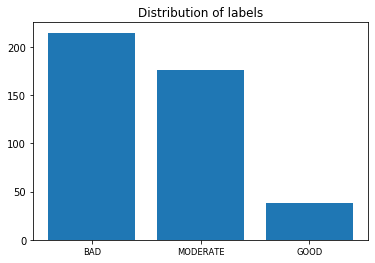

In [3]:
df = project_data['Label'].value_counts()
plt.bar(range(len(df)), df.values, align='center')
plt.xticks(range(len(df)), df.index.values, size='small')
plt.title('Distribution of labels')
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


<Figure size 720x720 with 0 Axes>

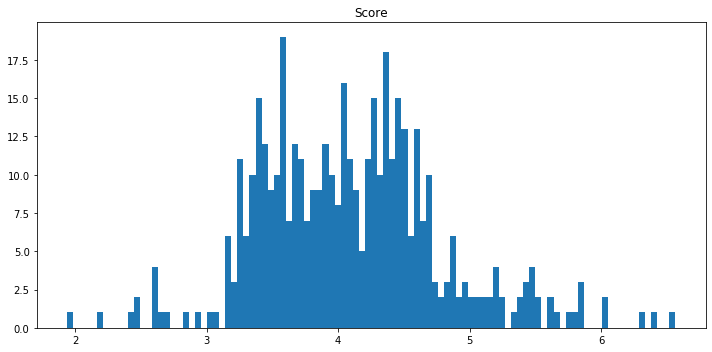

In [4]:
df = project_data
plt.figure(figsize=[10, 10])
f, ax = plt.subplots(1, 1)
f.set_figwidth(10)
f.set_figheight(5)
column = 'Score'
d = df[df[column] != 'N/A']
d = d.loc[:, column]
ax.hist(d, histtype='bar', bins=100)
ax.set_title(column)
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

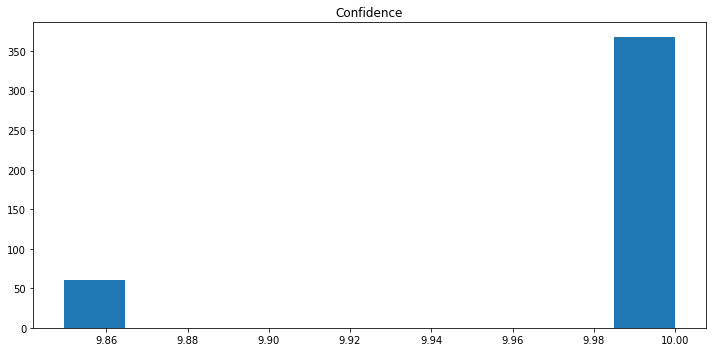

In [5]:
df = project_data
plt.figure(figsize=[10, 10])
f, ax = plt.subplots(1, 1)
f.set_figwidth(10)
f.set_figheight(5)
column = 'Confidence'
d = df[df[column] != 'N/A']
d = d.loc[:, column]
ax.hist(d, histtype='bar', bins=10)
ax.set_title(column)
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

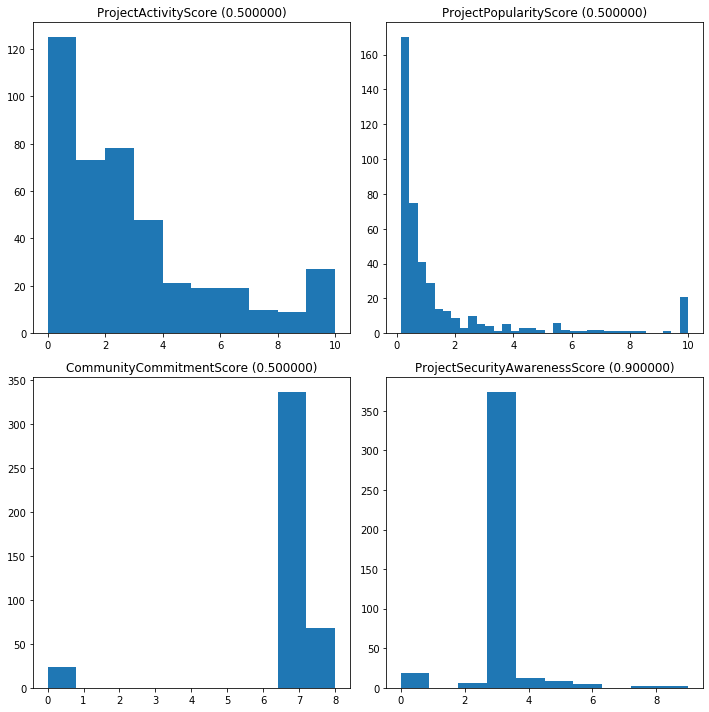

In [6]:
df = project_data[['ProjectActivityScore', 'ProjectPopularityScore', 
                   'CommunityCommitmentScore', 'ProjectSecurityAwarenessScore']]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(2, 2)
f.set_figwidth(10)
f.set_figheight(10)
a = a.ravel()
for idx, ax in enumerate(a):
    column = df.columns[idx]
    d = df[df[column] != 'N/A']
    d = d.iloc[:,idx]
    ax.hist(d, histtype='bar', bins='auto')
    ax.set_title('{} ({:f})'.format(column, score_weights[column]))
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

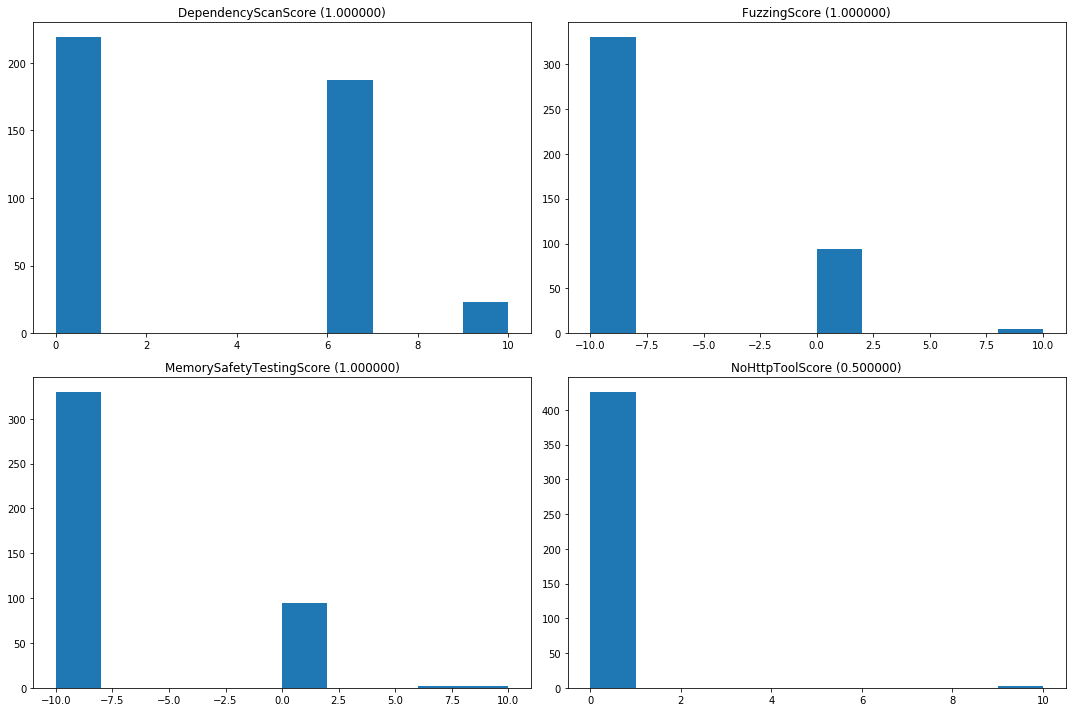

In [7]:
df = project_data[['DependencyScanScore', 'FuzzingScore', 
                   'MemorySafetyTestingScore', 'NoHttpToolScore']]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(2, 2)
f.set_figwidth(15)
f.set_figheight(10)
a = a.ravel()
for idx, ax in enumerate(a):
    column = df.columns[idx]
    d = df.replace('N/A', -10)
    d = d.iloc[:,idx]
    ax.hist(d, histtype='bar', bins='auto')
    ax.set_title('{} ({:f})'.format(column, score_weights[column]))
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

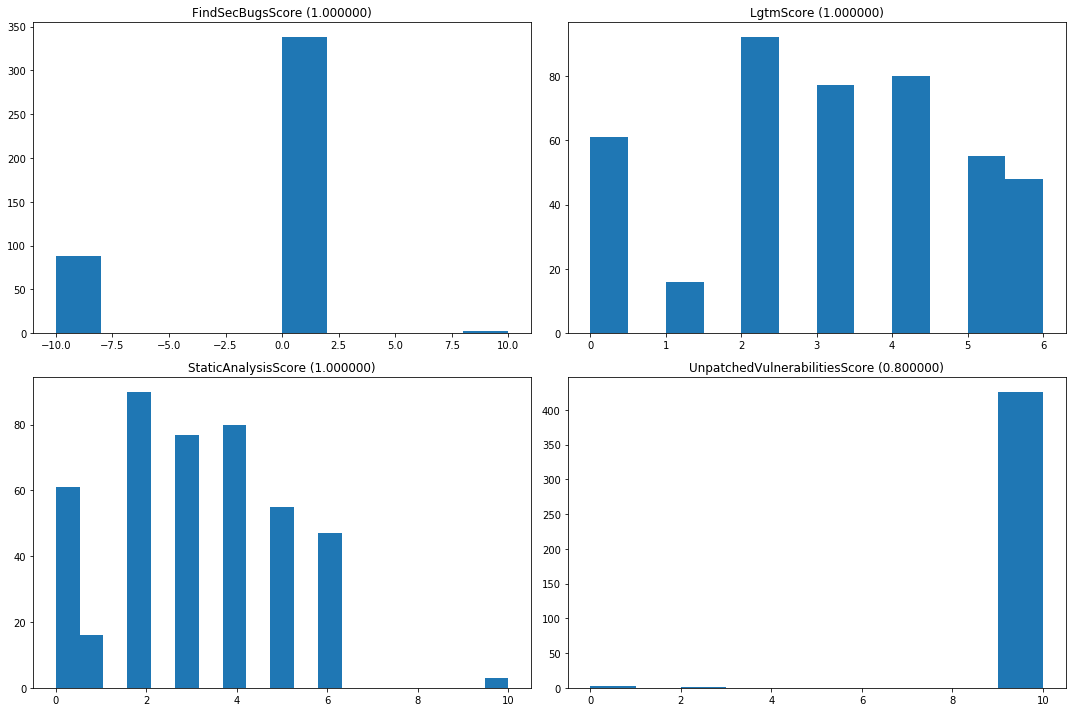

In [8]:
df = project_data[['FindSecBugsScore', 'LgtmScore', 'StaticAnalysisScore', 
                   'UnpatchedVulnerabilitiesScore']]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(2, 2)
f.set_figwidth(15)
f.set_figheight(10)
a = a.ravel()
for idx, ax in enumerate(a):
    if idx == len(df.columns): break
    column = df.columns[idx]
    d = df.replace('N/A', -10)
    d = d.iloc[:,idx]
    ax.hist(d, histtype='bar', bins='auto')
    ax.set_title('{} ({:f})'.format(column, score_weights[column]))
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

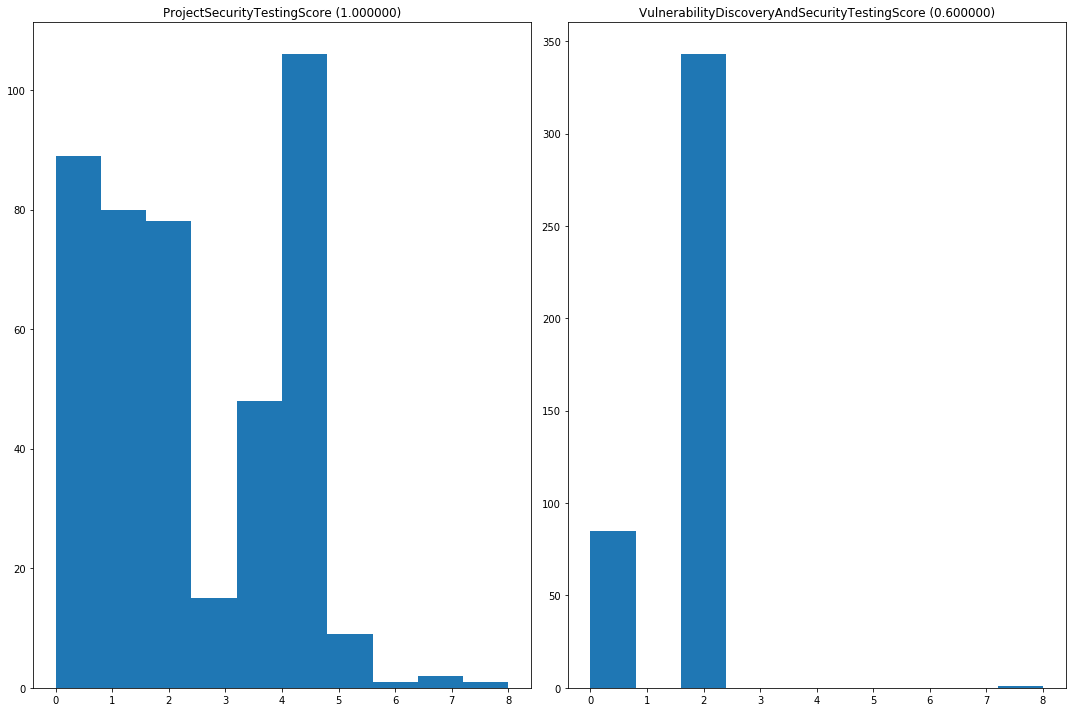

In [9]:
df = project_data[['ProjectSecurityTestingScore', 'VulnerabilityDiscoveryAndSecurityTestingScore']]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(1, 2)
f.set_figwidth(15)
f.set_figheight(10)
a = a.ravel()
for idx, ax in enumerate(a):
    if idx == len(df.columns): break
    column = df.columns[idx]
    d = df.replace('N/A', -10)
    d = d.iloc[:,idx]
    ax.hist(d, histtype='bar', bins='auto')
    ax.set_title('{} ({:f})'.format(column, score_weights[column]))
plt.tight_layout()

In [10]:
pd.DataFrame.from_dict(score_weights, orient='index')

,0
UnpatchedVulnerabilitiesScore,0.8
ProjectActivityScore,0.5
CommunityCommitmentScore,0.5
ProjectSecurityAwarenessScore,0.9
VulnerabilityDiscoveryAndSecurityTestingScore,0.6
ProjectSecurityTestingScore,1.0
StaticAnalysisScore,1.0
LgtmScore,1.0
FindSecBugsScore,1.0
NoHttpToolScore,0.5


In [11]:
project_data[
    ['URL', 
     '# of vulnerabilities', 
     '# of unpatched vulnerabilities', 
     '# of patched vulnerabilities']
][project_data['# of vulnerabilities'] > 3].sort_values(by = '# of vulnerabilities', ascending=False)

,URL,# of vulnerabilities,# of unpatched vulnerabilities,# of patched vulnerabilities
362,https://github.com/openssl/openssl,218,0,218
278,https://github.com/apache/tomcat,183,0,183
280,https://github.com/apache/tomcat80,183,0,183
268,https://github.com/apache/struts,77,0,77
270,https://github.com/apache/subversion,69,0,69
...,...,...,...,...
144,https://github.com/apache/groovy,4,0,4
166,https://github.com/apache/jackrabbit-oak,4,0,4
170,https://github.com/apache/kafka,4,0,4
214,https://github.com/apache/pdfbox,4,0,4


In [12]:
project_data[
    ['URL', 
     '# of vulnerabilities', 
     '# of vulnerabilities without introduced date', 
     '# of vulnerabilities without fixed date']
][project_data['# of vulnerabilities'] > 3].sort_values(by = '# of vulnerabilities', ascending=False)

,URL,# of vulnerabilities,# of vulnerabilities without introduced date,# of vulnerabilities without fixed date
362,https://github.com/openssl/openssl,218,218,218
278,https://github.com/apache/tomcat,183,183,183
280,https://github.com/apache/tomcat80,183,183,183
268,https://github.com/apache/struts,77,77,77
270,https://github.com/apache/subversion,69,69,69
...,...,...,...,...
144,https://github.com/apache/groovy,4,4,4
166,https://github.com/apache/jackrabbit-oak,4,4,4
170,https://github.com/apache/kafka,4,4,4
214,https://github.com/apache/pdfbox,4,4,4


In [13]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def draw_boolean_hists(df, columns, a):
    a = a.ravel()
    for idx, ax in enumerate(a):
        if idx == len(df.columns): break
        column = df.columns[idx]
        if column not in columns: continue
        vc = df[column].replace(True, 'Yes').replace(False, 'No').value_counts().to_dict()
        if 'Yes' not in vc: vc['Yes'] = 0
        if 'No' not in vc: vc['No'] = 0
        if 'unknown' not in vc: vc['unknown'] = 0
        rects = ax.bar(vc.keys(), vc.values(), width=0.5)
        autolabel(rects)
        ax.set_title(column)

<Figure size 720x720 with 0 Axes>

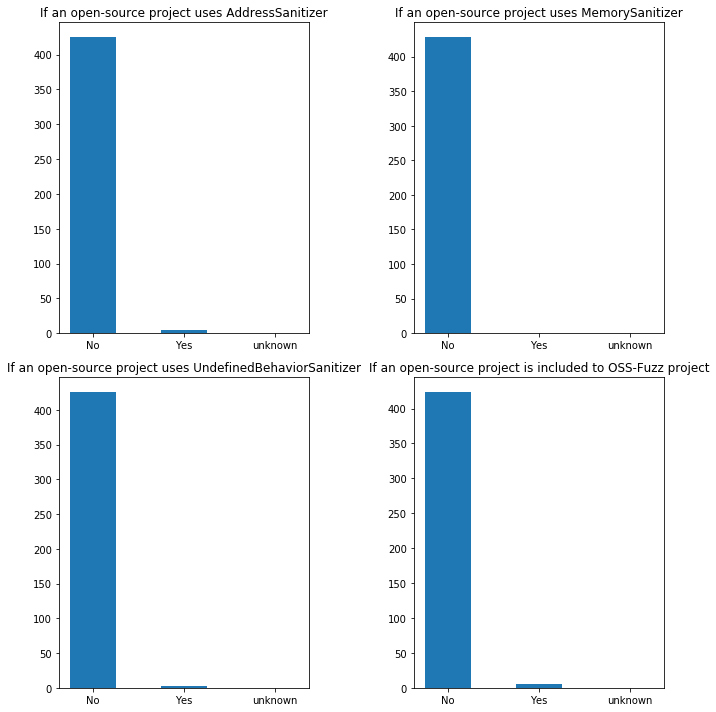

In [14]:
columns = [
    'If an open-source project uses AddressSanitizer', 
    'If an open-source project uses MemorySanitizer',
    'If an open-source project uses UndefinedBehaviorSanitizer',
    'If an open-source project is included to OSS-Fuzz project',
]

df = project_data[columns]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(2, 2)
f.set_figwidth(10)
f.set_figheight(10)
draw_boolean_hists(df, columns, a)
f.tight_layout()

<Figure size 720x720 with 0 Axes>

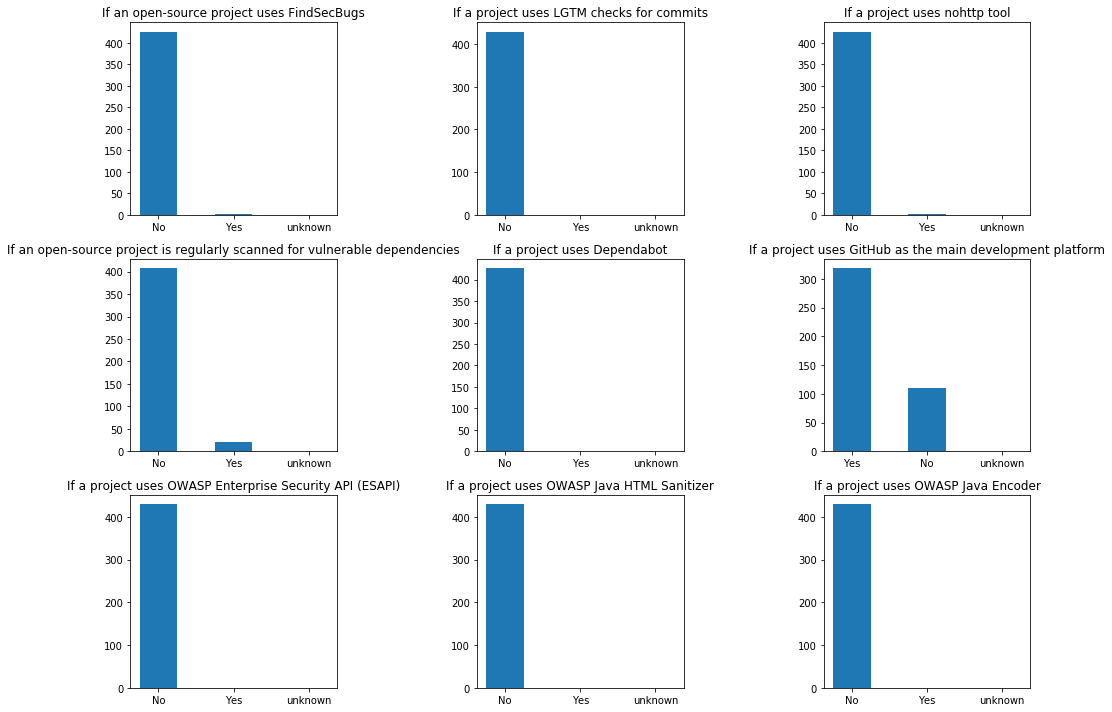

In [15]:
columns = [    
    'If an open-source project uses FindSecBugs',
    'If a project uses LGTM checks for commits',
    'If a project uses nohttp tool',
    'If an open-source project is regularly scanned for vulnerable dependencies',
    'If a project uses Dependabot',
    'If a project uses GitHub as the main development platform',
    'If a project uses OWASP Enterprise Security API (ESAPI)',
    'If a project uses OWASP Java HTML Sanitizer',
    'If a project uses OWASP Java Encoder'
]

df = project_data[columns]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(3, 3)
f.set_figwidth(15)
f.set_figheight(10)
draw_boolean_hists(df, columns, a)
f.tight_layout()

<Figure size 720x720 with 0 Axes>

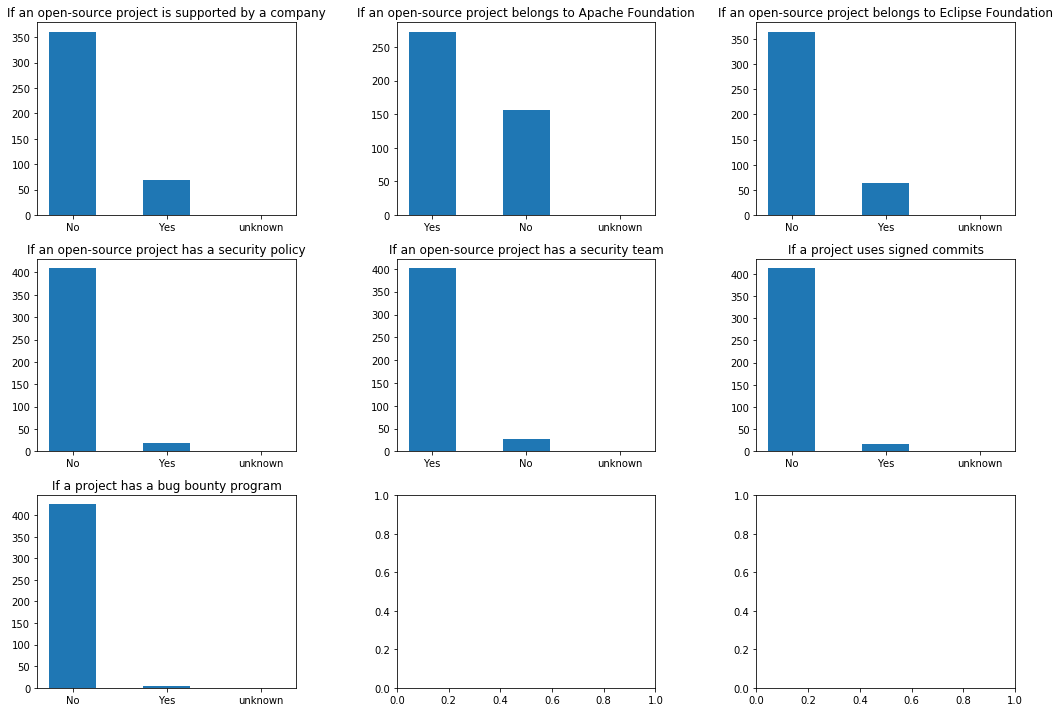

In [16]:
columns = [        
    'If an open-source project is supported by a company',
    'If an open-source project belongs to Apache Foundation',
    'If an open-source project belongs to Eclipse Foundation',
    'If an open-source project has a security policy',
    'If an open-source project has a security team',
    'If a project uses signed commits',
    'If a project has a bug bounty program',
]

df = project_data[columns]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(3, 3)
f.set_figwidth(15)
f.set_figheight(10)
draw_boolean_hists(df, columns, a)
f.tight_layout()

In [17]:
unclear_threshold = 8.0

bad_ratings_fraction = 0.30
moderate_ratings_fraction = 0.50
good_ratings_fraction = 0.20

if bad_ratings_fraction + moderate_ratings_fraction + good_ratings_fraction != 1:
    raise Exception('Oops!')

n = len(project_data.index)
target_bad_ratings_number = bad_ratings_fraction * n
target_moderate_ratings_number = moderate_ratings_fraction * n
    
moderate_threshold = 0
good_threshold = 0
i = 0
for index, value in project_data['Score'].sort_values().items():
    i = i + 1
    if moderate_threshold == 0 and i > target_bad_ratings_number:
        moderate_threshold = value
        i = 0
    if good_threshold == 0 and i > target_moderate_ratings_number:
        good_threshold = value
        break
        
print('New threshold for MODERATE = {:f}'.format(moderate_threshold))
print('New threshold for GOOD     = {:f}'.format(good_threshold))

New threshold for MODERATE = 3.678750
New threshold for GOOD     = 4.583097


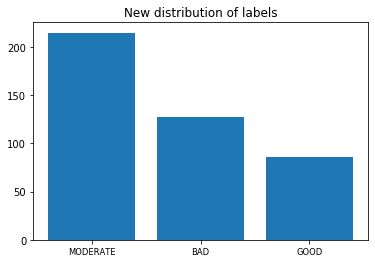

In [18]:
def get_new_label(row):
    s = row['Score']
    c = row['Confidence']
    if c < unclear_threshold: return 'UNCLEAR'
    if s >= good_threshold: return 'GOOD'
    if s >= moderate_threshold: return 'MODERATE'
    return 'BAD'

project_data['Label'] = project_data.apply(lambda row: get_new_label(row), axis=1)
df = project_data['Label'].value_counts()
plt.bar(range(len(df)), df.values, align='center')
plt.xticks(range(len(df)), df.index.values, size='small')
plt.title('New distribution of labels')
plt.show()

In [19]:
# save the new thresholds
data = {}
data['moderate'] = moderate_threshold
data['good'] = good_threshold
data['unclear'] = unclear_threshold
filename = '../../../../../src/main/resources/com/sap/sgs/phosphor/fosstars/model/rating/oss/OssSecurityRatingThresholds.json'
with open(filename, 'w') as file:
    json.dump(data, file, sort_keys=True, indent=2)